A quick warning: If you are scraping external websites, be sure you are allowed to scrape it, especially be careful if you are scraping personal data. A short information about GDPR for web scraping: https://blog.scrapinghub.com/web-scraping-gdpr-compliance-guide. This is NOT legal advice, for further information, please contact the legal team. Also make sure to scrape not to often from same ip adress this may cause a detection of you as a bot and may ban you from access.

If you want to learn more about web scraping, please find the tutorials in our knowledge collection.

This notebook uses Python +3.6

In [1]:
# common imports
import os
import re
import sys
import csv
import time
import random
import collections
import numpy as np
import matplotlib.pyplot as plt

# syncronious web scraping imports
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import requests

# asyncronious webscraping imports
# important - use tornado < 5.0 to use it in notebook
# pip install tornado==4.5.3
import asyncio
import aiohttp

# text processing tools
from somajo import Tokenizer, SentenceSplitter

# url from the A1 community
base_url = 'https://www.a1community.net/'

## Data Scraping
Requesting the data from the website and scraping the htmls for the required texts. Requesting is done by two stages. The first stage is requesting all quicklinks of a topic and the second one is requesting all articles regarding the quicklink underlying topic. This is done by using ascnycronious reqeuesting to save time. To learn more about efficient requesting and html scraping, look inside the knowledge collection.

In [2]:
def quicklink_scraper(topics, base='https://www.a1community.net/'):
    """method scrapes the quicklink hrefs for all topics
    
    Comment:
    - created for a1.community html structure
    
    Keyword arguments:
    base -- the url to request
    topics -- the topics from the website to scrape from

    """    
    # requesting the html file from the webpage
    try:
        source = requests.get(base, timeout=10)
    except e:
        return(e)
    
    # handeling possible bad html formats
    soup = BeautifulSoup(source.text, 'lxml')
    
    # scrape boxes with content links
    boxes = soup.find_all('div', class_='box box__pad')[1:]
    
    # get only high level topic boxes
    boxes =  [
        box for box in boxes
        if box.h2.a.get('id') in topics
    ]
    
    # scrape quicklinks in boxes
    quicklinks = [
        [box.h2.a.get('id'),
         quicklink]
        for box in boxes  
        for quicklink in box.find_all(class_='user_data flag__body')
        if quicklink.h3
    ]
    
    # get page amounts for quicklinks
    pages_ = [
        quicklink.ul.find(
        'li',
        class_='qa-forum-overview-topic-counter'
        ).text
        for _, quicklink in quicklinks
    ]
    
    pages_ = [
        int(s) 
        for pages in pages_
        for s in pages.replace(".","").split() 
        if s.isdigit()
    ]
    
    # go over all pages for every quicklink 
    # get hrefs
    quicklink_list = []
    for i, quicklink in enumerate(quicklinks):
        j = 0
        while pages_[i]-25*j > 0:
            quicklink_list.append([
                quicklink[0],
                (quicklink[1].h3.a.get('href')+
                '/index'+str(j+1)+'.html'),
            ])
            j+=1
    return quicklink_list

In [3]:
async def fetch(session, url, label):
    """method fetches the given url 
    
    Keyword arguments:
    session -- the ClientSession form aiohttp
    url -- url to fetch
    label -- label for the url content
    """
    async with session.get(url, timeout=60 * 60) as response:
        result = await response.text()
        return [label, result]

In [4]:
async def fetch_all(quicklinks, loop):
    """method collects multiple fetch tasks
    
    Keyword arguments:
    quicklinks -- the urls to fetch
    loop -- current loop from asyncio to add tasks to
    """
    connector = aiohttp.TCPConnector(limit=100)
    async with aiohttp.ClientSession(loop=loop, connector=connector) as session:
        results = await asyncio.gather(*[fetch(session, base_url+url, label) 
                                         for label, url in quicklinks],
        return_exceptions=True)
        return results

In [5]:
def get_htmls(urls):
    """method organizes the async requesting
    
    Keyword arguments:
    urls -- urls to request
    """
    if len(urls) > 1:
        loop = asyncio.get_event_loop()
        htmls = loop.run_until_complete(fetch_all(urls, loop))
        raw_result = htmls
    return raw_result

In [6]:
# get BeautifulSoup search faster
only_article_tags = SoupStrainer(
    class_ = 'thread-list-block__text-col'
)

only_post_tags = SoupStrainer(
    class_="post__content js-content--original qa-topic-post-content"
)

In [8]:
def super_scraper(quicklinks=quicklink_scraper('internet')):
    """method returns a labeled list of raw article texts
    
    Comment:
    - uses the asyncronious fetchers
    - filters only the original poster text, not support team
    - created for a1.community html structure
    """
    # request all quicklink htmls
    print('start requesting quicklink htmls')
    ts = time.time()
    responses = get_htmls(quicklinks)
    print('successfully collected quicklink htmls in %.2f sec.' %(time.time()-ts))
    
    # filter the quicklink htmls for article urls
    print('start scraping the quicklink htmls')
    ts = time.time()
    quicklink_htmls = [
        [label, BeautifulSoup(html, 'lxml', parse_only=only_article_tags)]
        for label, html in responses
        if html
    ]
    
    articles = [
        [label, html.find_all('div', class_ = 'thread-list-block__text-col')]
        for label, html in quicklink_htmls
    ]
    
    flat_articles = [
        [sublist[0], item.h4.a.get('href')] 
        for sublist in articles 
        for item in sublist[1]
        if not "A1_" in item.find(class_="thread-list-block__header qa-topic-block-icon").a.text
    ]
    print('successfully scraped the quicklink htmls in %.2f sec.' %(time.time()-ts))
    
    # request all article htmls
    print('start requesting the article texts')
    ts = time.time()
    responses = get_htmls(flat_articles)
    print('successfully collected the article texts in %.2f sec.' %(time.time()-ts))
    
    # filter article htmls for the texts
    print('start scraping the article htmls')
    ts = time.time()
    article_htmls = [
        [label, BeautifulSoup(article, 'lxml', parse_only=only_post_tags)]
        for label, article in responses
        if article
    ]
    
    article_texts = [
        [
            label,
            article.find(class_ = "post__content js-content--original qa-topic-post-content").text,
        ]

        for label, article in article_htmls
        if article.find(class_ = "post__content js-content--original qa-topic-post-content")
    ]
    print('successfully scraped the article htmls in %.2f sec.' % (time.time()-ts))
    
    return article_texts

## Data Exploration
We have to be aware that there are community moderators that are moving messages and that in our community data there may be wordphrases that gets our texts dirty.

In [9]:
topics = ['internet', 'smartphones', 'tv', 'vertrag']

In [10]:
article_texts = super_scraper(quicklink_scraper(topics))

start requesting quicklink htmls
successfully collected quicklink htmls in 41.61 sec.
start scraping the quicklink htmls
successfully scraped the quicklink htmls in 55.66 sec.
start requesting the article texts
successfully collected the article texts in 425.44 sec.
start scraping the article htmls
successfully scraped the article htmls in 382.47 sec.


In [11]:
# output on the website
for i in range(5):
    print(article_texts[i][1])


        Hallo Leute,
habe den Mobilen-Tarif mit den Geschwindigkeiten 80/20 Mbit/s. Die 80 Mbit/s download erreiche ich meistens ganz gut, Probleme macht der schwache Upload mit nicht einmal 2 Mbit/s.
Hardware: Huawei B618s-22d
Empfang: gut bis sehr gut
Hat jemand Tipps?
Danke!

                
            

        Seit der Geschichte mit dem angeblichen Hackerangriff im Oktober des vergangenen Jahres (ist schon einige Zeit her) spießt es sich mit dem Zugriff auf meine Seite members.aon.at/hydro3193. Etliche mails an A1-service brachten keine verwertbaren Antworten hervor. Nun möchte ich endlich einmal wissen, woran das Desaster liegt.
Gruß hsmounty

                
            

        Hallo, meine alten erstellen Alias Adressen funktionieren extern nicht

kann es sein, dass eine alias adresse die länger nicht verwendet wird, abgeschaltet wird?
alle meine 4 alten alias Adressen funktionieren extern nicht mehr!
Sende ich aber eine mail von menen webmail an mich selbst kommen sie a

In [12]:
# output on the website
for i in range(5):
    print(repr(article_texts[i][1])+'\n\n')

'\n        Hallo Leute,\r\nhabe den Mobilen-Tarif mit den Geschwindigkeiten 80/20 Mbit/s. Die 80 Mbit/s download erreiche ich meistens ganz gut, Probleme macht der schwache Upload mit nicht einmal 2 Mbit/s.\r\nHardware: Huawei B618s-22d\r\nEmpfang: gut bis sehr gut\r\nHat jemand Tipps?\r\nDanke!\n\n                \n            '


'\n        Seit der Geschichte mit dem angeblichen Hackerangriff im Oktober des vergangenen Jahres (ist schon einige Zeit her) spießt es sich mit dem Zugriff auf meine Seite members.aon.at/hydro3193. Etliche mails an A1-service brachten keine verwertbaren Antworten hervor. Nun möchte ich endlich einmal wissen, woran das Desaster liegt.\r\nGruß hsmounty\n\n                \n            '


'\n        Hallo, meine alten erstellen Alias Adressen funktionieren extern nicht\n\r\nkann es sein, dass eine alias adresse die länger nicht verwendet wird, abgeschaltet wird?\r\nalle meine 4 alten alias Adressen funktionieren extern nicht mehr!\r\nSende ich aber eine mail

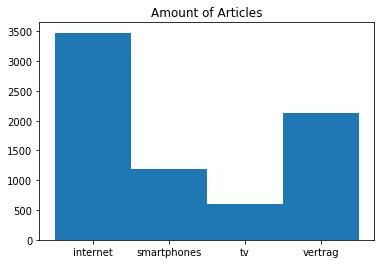

In [13]:
# plotting the amount of articles per topic

top = [[label, len([l for l in article_texts if l[0] ==label])] for label in topics]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center', tick_label=topics)

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(list(range(0, 4000, 500)))

plt.title('Amount of Articles')
plt.show()

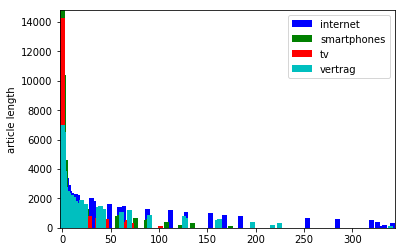

In [14]:
# show the length of article_texts
ax = plt.subplot(111)
col = ['b', 'g', 'r', 'c', 'y']
for i, label in enumerate(topics):
    top_x = []
    top_y = []
    len_top = [len(l[1]) for l in article_texts if l[0]==label]
    for z in range(0, max(len_top)-100, 100):
        top_y.append(z)
        top_x.append(len([x for x in len_top if z <= x <= z+100]))
    ax.bar(top_x, top_y,width=5,color=col[i],align='center')
    
ax.autoscale(tight=True)

ax.set_ylabel('article length')
ax.legend( topics )



plt.show()

In [15]:
# finding duplicated messages that may have no information
texts = [text for _, text in article_texts]
print([(item,count) for item, count in collections.Counter(texts).items() if count > 1])
trash_texts = [item for item, count in collections.Counter(texts).items() if count > 1]

[('\n        Dieser Beitrag wurde von einem Moderator an eine thematisch passendere Stelle verschoben.\n\n                \n            ', 413), ('\n\n', 8), ('\n        .\n', 9)]


In [16]:
# more duplicates - sentences that occurr more often
tokenizer = Tokenizer(split_camel_case=True, token_classes=False, extra_info=False)
sentence_splitter = SentenceSplitter(is_tuple=False)

tokens = [tokenizer.tokenize_paragraph(paragraph)
          for paragraph in texts]

sentences = [sentence_splitter.split(token)
            for token in tokens]

In [17]:
# often used words
flat_words = [item for sublist in tokens for item in sublist]

duplicates = sorted(
    [
        (count, item) 
        for item, count in collections.Counter(flat_words).items() 
        if count > 150
    ],
    reverse=True
)

for duplicate in duplicates:
    print(duplicate)
    
# the words 'icon', 'Community', 'Info', 'Fehlermeldung' appear as some commenting 
# introduction from a community moderator
trash_maybes = ['icon', 'Community', 'Info', 'Fehlermeldung']

(35489, '.')
(35316, ',')
(17922, 'ich')
(14167, 'die')
(14081, 'und')
(12091, 'das')
(10736, 'der')
(9399, 'A1')
(9376, 'nicht')
(8493, 'ist')
(7959, ')')
(7831, '?')
(7654, 'von')
(7641, '(')
(7546, 'mit')
(7486, 'es')
(6562, 'habe')
(6499, ':')
(6494, 'auf')
(6238, '"')
(5879, 'auch')
(5782, 'zu')
(5564, 'den')
(5498, 'ein')
(5419, 'in')
(5402, 'eine')
(5120, 'bei')
(5104, '!')
(5027, 'Ich')
(4960, 'für')
(4704, 'mir')
(4679, 'kann')
(4450, 'Hallo')
(4268, 'im')
(3756, '-')
(3699, 'aber')
(3662, 'dass')
(3214, 'nur')
(3157, 'dem')
(3153, 'einen')
(3134, 'noch')
(3106, 'an')
(3026, 'oder')
(2988, 'da')
(2872, 'man')
(2816, '/')
(2804, 'wird')
(2751, 'dann')
(2648, 'Antwort')
(2647, 'hat')
(2615, 'schon')
(2448, 'mehr')
(2423, 'sich')
(2318, 'über')
(2300, 'wie')
(2277, 'anzeigen')
(2267, 'wenn')
(2266, 'Beste')
(2263, 'am')
(2238, 'Original')
(2232, 'wieder')
(2224, 'icon')
(2192, 'um')
(2188, 'wurde')
(2149, 'einem')
(2141, 'mich')
(2060, 'so')
(1981, 'keine')
(1889, 'was')
(1888, '

In [18]:
# explore the potential trash keywords
for trash in trash_maybes:
    print(trash+"\n"+"_"*50+"\n")
    i = 0
    for text in texts:
        if trash in text:
            print(text)
            i += 1
            if i > 1:
                break
                
# it seems like the icons are just introducing a common message
# Fehlermeldungen are just printed out to the community
# there are some customers that use the structure "a:b \n c:d \n ..." to point out informations

icon
__________________________________________________


        Hallo, 
ich scheitere gerade daran duckdns auf der Hybrid Box einzurichten. 
Folgende Daten habe ich von duckdns:
account: meineemail@a1.com
token: AAAA
domain: xxxx
adresse?: http://xxxx.duckdns.org

Ich bin mir nun nicht sicher, was wo in der Benutzeroberfläche des Modem eingetragen werden muss. Bei den meisten Versuchen bekomme ich die Meldung "Hostname invalid".
Hier ein Bild. 


Token ist klar. 
Domäne = xxxx   ?
Hostname? 

Danke!

                            


icon
Beste Antwort von jo93  7. August 2018, 18:42
Probiere die Aufteilung 
bei xxxx.duckdns.org
-> Hostname: xxxx
-> Domain: duckdns.org
Original anzeigen



        Hallo ich hätte eine Frage kann mir das 1a Team den nat typ auf offen  bekomme  weil ich auf der ps4 Spiele und daher immer wieder Probleme auftreten was eigentlich relativ nervt und ich daher im Internet gelesen habe das ein nat typ der offen ist sehr gut sein sollte 
Bitte liebes a1 Team hil

In [19]:
flat_sentences = [" ".join(item) for sublist in sentences for item in sublist]

duplicates = sorted(
    [
        (count, item) 
        for item, count in collections.Counter(flat_sentences).items() 
        if count > 3
    ],
    reverse=True
)

for duplicate in duplicates:
    print(duplicate)
    
# The sentences 
# 'Orginal anzeigen.',
# 'Dieser Beitrag wurde von einem Moderator an eine thematisch passendere Stelle verschoben.'
# '" Original anzeigen'
# and the phrase 'Orginal anzeigen' in general don't appear as
# information rich
trash_phrases = ['Orginal anzeigen']

(637, 'Original anzeigen')
(522, 'Hallo !')
(415, 'Dieser Beitrag wurde von einem Moderator an eine thematisch passendere Stelle verschoben .')
(100, 'Danke !')
(94, 'LG')
(89, 'Hallo .')
(87, 'Danke')
(54, 'Vielen Dank !')
(47, 'Lg')
(44, 'Lg Kornelia Original anzeigen')
(44, 'Gruß Christian Original anzeigen')
(42, 'Danke .')
(37, 'Hallo Community !')
(36, 'LG Frederic Original anzeigen')
(35, 'Liebe Grüße , Alexandra Original anzeigen')
(35, 'Hallo liebe Community !')
(31, 'Hallo zusammen !')
(30, 'Hi !')
(30, 'Guten Tag !')
(28, 'Mfg')
(28, 'LG Nerd Tech Original anzeigen')
(24, 'Vielen Dank')
(24, 'Liebe Grüße , Patrick Original anzeigen')
(22, 'Woran kann das liegen ?')
(22, 'LG Mathias Original anzeigen')
(22, 'Hallo Leute !')
(21, 'Liebe Grüße')
(21, 'LG Lis Original anzeigen')
(21, 'Danke im Voraus !')
(20, 'Liebe Community !')
(20, 'Bitte um Hilfe .')
(20, 'Bitte um Hilfe !')
(18, 'Was kann ich tun ?')
(18, 'Vielen Dank .')
(17, 'MfG')
(16, 'Mit freundlichen Grüßen')
(15, 'Li

## General Data Cleaning 
From the text examples one can make some ideas how to do basic cleanings. We don't want to go into too much detail here because there are multiple ways to prepare data and some will hurt the output of some models.

Trash texts can be removed. Nevertheless we are facing some problems with the trash candidates. As we saw there are customers printing out there Fehlermeldungen and giving unrich (for our task) informations in some format "a:b \n c:d \n ...". For now let us include them but we keep them in mind for further research.

To learn more about this problem, look inside the knowledge collection.

In [20]:
print("Before cleaning we have %i texts." %len(article_texts))

Before cleaning we have 7393 texts.


In [21]:
# cleaning trash texts
article_texts = [
    text 
    for text in article_texts
    if not text[1] in trash_texts
]
print(len(article_texts), "texts are left.")

6963 texts are left.


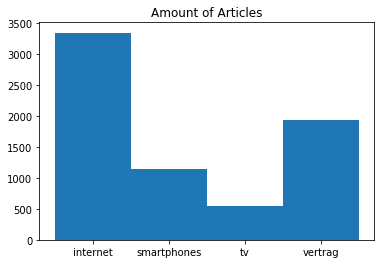

In [22]:
# plotting the amount of articles per topic

top = [[label, len([l for l in article_texts if l[0] ==label])] for label in topics]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center', tick_label=topics)

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(list(range(0, 4000, 500)))

plt.title('Amount of Articles')
plt.show()

In [23]:
# cleaning trash phrases
article_texts = [[text[0], re.sub(trash_phrases[0], '', text[1])] 
    for text in article_texts]

In [24]:
# cleaning trash candidates
# more specific cleaning the icon appendix
stopper = 'icon'
article_texts = [
    [
        text[0],
        text[1][:text[1].find(stopper)]
    ]
    for text in article_texts]

In [25]:
# cleaning newlines and carriage-returns and ";" for delimitering 
article_texts = [[text[0],re.sub("[\n\r;]", ' ', text[1])]
                 for text in article_texts]

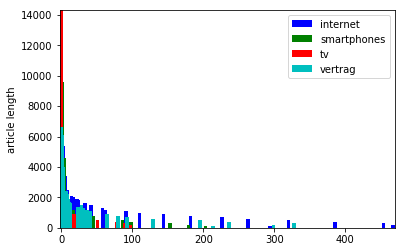

In [26]:
# show the length of article_texts
ax = plt.subplot(111)
col = ['b', 'g', 'r', 'c', 'y']
for i, label in enumerate(topics):
    top_x = []
    top_y = []
    len_top = [len(l[1]) for l in article_texts if l[0]==label]
    for z in range(0, max(len_top)-100, 100):
        top_y.append(z)
        top_x.append(len([x for x in len_top if z <= x <= z+100]))
    ax.bar(top_x, top_y,width=5,color=col[i],align='center')
    
ax.autoscale(tight=True)

ax.set_ylabel('article length')
ax.legend( topics )



plt.show()

## Save the Cleaned Data

In [27]:
# be aware of the delimiter ";" 
# as our text includes los of "," we have to set it different
if not os.path.isdir("./data"):
    os.mkdir("./data")
with open(os.path.join("./data", "output.csv"), "w", encoding='utf-8') as f:
    writer = csv.writer(f, delimiter=";")
    writer.writerows(article_texts)